# PyThia

PyThia performs video prediction for simple physical systems:
given initial video frames, what will a future video frame look like?

## Technical preliminaries

We install the `pythia` package and import it.
We also import other libraries, or tools from other libraries, which will be of use.

In [ ]:
pip install git+https://github.com/aremondtiedrez/pythia.git

In [2]:
from IPython.display import HTML
from keras.optimizers import Adam

import pythia

## Getting familiar with the data

The objective of PyThia is, humbly, to predict the future.
That being said, it does so in a very restricted context.

The only data that PyThia models ever see consists in a single ball
bouncing around a box. More precisely, the data consists in snapshots,
evenly spaced in time, of that ball's position.

We must make an important distinction here: PyThia models
are fed *raw image data*. They are not told what the exact position of the ball is, or what its exact velocity is. They are certainly not told anything about the laws of physics or the equations governing elastic collisions between
a ball and a box's walls. These are all things that the models will infer,
to the extend that it helps them fulfill their prediction task.

The task that PyThia models handle is then the following:
given a series of snapshots, can we predict the image that will be captured
a few moments in the future?

In this notebook, there are two easy ways to get your hands on data.
1. Load the demonstration data.
2. Generate (randomly) your own data.

In [3]:
# Load the demonstration data
snapshot_timesteps, positions, velocities, images = pythia.demo.load_data()

# Generate your own data
# (As the number of samples increases, this can become a somewhat lengthy process)
snapshot_timesteps, positions, velocities, images = pythia.data_generation.generate(n_samples=10)

Whichever way you got your hands on data, you can take a look at individual samples in the same way.

In [4]:
# Remember: each sample is a sequence of images.
# To see what they look like, in sequence, you can create and
# display a short animation.
sample = images[0]
animation = pythia.visualization.create_animation(sample, display_walls=True)
HTML(animation.to_jshtml())

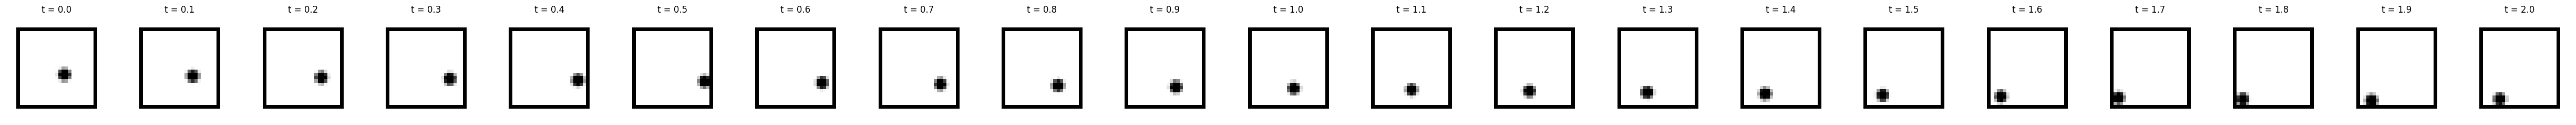

Initial velocity:    [171.57 -44.02]
Position at t = 0.0: [153.86 103.42]
Position at t = 0.1: [171.02  99.02]
Position at t = 0.2: [188.18  94.61]
Position at t = 0.3: [205.51  90.17]
Position at t = 0.4: [222.49  85.81]
Position at t = 0.5: [232.44  81.41]
Position at t = 0.6: [215.12  76.96]
Position at t = 0.7: [198.13  72.6 ]
Position at t = 0.8: [180.97  68.2 ]
Position at t = 0.9: [163.81  63.8 ]
Position at t = 1.0: [146.66  59.4 ]
Position at t = 1.1: [129.5  55. ]
Position at t = 1.2: [112.17  50.55]
Position at t = 1.3: [95.19 46.19]
Position at t = 1.4: [78.03 41.79]
Position at t = 1.5: [60.87 37.39]
Position at t = 1.6: [43.71 32.99]
Position at t = 1.7: [26.38 28.54]
Position at t = 1.8: [30.33 24.19]
Position at t = 1.9: [47.49 20.14]
Position at t = 2.0: [64.65 24.54]


In [5]:
# You can also visualize that same sample by plotting all of its images side-by-side
# (This will also show the initial velocity and the positions of the ball at each time
# when an image has been captured. Remember: the PyThia models never see this information.
# Nonetheless, it can sometimes can in handy to have access to it.)
index = 0
pythia.visualization.inspect_sample(index, snapshot_timesteps, positions, velocities, images, display_walls=True)

## Training the model

Since we are dealing with a computer vision task,
a natural starting point is to use a deep learning approach.

The model architecture we have found to be successful has two components.
- An *encoder*-*decoder* pair consisting of convolutional neural networks
  which map between the raw image data and a learned latent space embedding.
- A *predictor* network which, given a series of past embeddings,
  predicts the embedding of the next image to come.

<img src="https://raw.githubusercontent.com/aremondtiedrez/pythia/main/pythia/demo/architecture.png" width="800">

It turns out that the training process goes more smoothly if the encoder-decoder
pair is pre-trained becfore the full encoder-predictor-decoder architecture is trained.

### Pre-training the encoder-decoder pair

We wish to pre-train the encoder-decoder pair so that the learned embedding
is then useful when predicting the future trajectory from past observations.

To do so, we will train the encoder-decoder pair as part
of a predictive model which, given two images recorded at times $t_1$ and
$t_2$, must predict the image at time $t_3$.
(Where the times are equally spaced, i.e. $t_3 - t_2 = t_2 - t_1$.)

The key is this: the model is constrained to learn a *linear relationship*
between the given embeddings of the first two images and
the prediction of the third image.

The idea is that this constraint forces the model to learn an embedding
which contains rich information for the prediction of future dynamics.

In order to do this, we collect data specifically curated to avoid collisions between the ball and the walls. Once again, that data may be loaded from
the demonstration data or generated here.

In [6]:
# Load the demonstration data
snapshot_timesteps, positions, velocities, images = pythia.demo.load_data(kind="collisionless")

# Generate your own data
# (As the number of samples increases, this can become a somewhat lengthy process)
snapshot_timesteps, positions, velocities, images = pythia.data_generation.generate(n_samples=10, max_timestep=0.3, ensure_no_collisions=True)

# These are the parameters that were used to generate the `collisionless` demonstration data:
#snapshot_timesteps, positions, velocities, images = pythia.data_generation.generate(n_samples=10_000, max_timestep=0.3, ensure_no_collisions=True, monitor_progress=True)

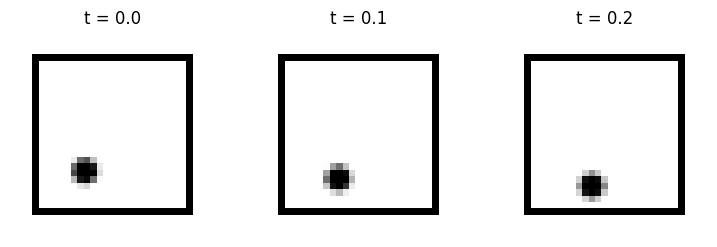

Initial velocity:    [ 121.65 -117.91]
Position at t = 0.0: [84.26 65.13]
Position at t = 0.1: [96.43 53.34]
Position at t = 0.2: [108.59  41.55]


In [7]:
# This collision-less data can be inspected and animated as before.

# Inspection
index = 0
pythia.visualization.inspect_sample(index, snapshot_timesteps, positions, velocities, images, display_walls=True)

# Animation
sample = images[index]
animation = pythia.visualization.create_animation(sample, display_walls=True)
HTML(animation.to_jshtml())

We can now train this so-called *memoryless* model
(it is called this because it predicts the future based only
on the immediate past, without any memory of what came before),
specifically in order to pre-train the encoder-decoder pair.

In [8]:
# First, we pre-process the data
img0 = images[:, 0].astype("float") / 255.
img1 = images[:, 1].astype("float") / 255.
img2 = images[:, 2].astype("float") / 255.

In [9]:
# Build the model
memoryless_model = pythia.models.Memoryless(img_shape=(32, 32, 1), latent_dim=12)
memoryless_model.compile(optimizer=Adam(learning_rate=1e-4))

In [10]:
# Train the model
# (This typically requires changing the Google Colab runtime type to use a GPU.
# Alternatively, the result of this training has already been saved
# as part of the Pythia package and can be explored below)
memoryless_model.fit([img0, img1, img2], epochs=5, batch_size=16)

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 2.0850
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 2.0824
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 2.0795
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 2.0772
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 2.0746


In [ ]:
# [OPTIONAL] If you have trained the memoryless model from scratch,
# then you can save the weights of its encoder-decoder pair for later use.
# This is optional since these weights are already saved in PyThia.
#memoryless_model.encoder.save_weights("memoryless_encoder.weights.h5")
#memoryless_model.decoder.save_weights("memoryless_decoder.weights.h5")

In [11]:
# Alternatively, if you did not retrain the memoryless model from scratch,
# you can load the model directly from the `demo` module of PyThia.
memoryless_model = pythia.demo.load_model(name="memoryless_full")

# For later purposes we need only have access to the encoer-decoder pair,
# not to the full model.
encoder = pythia.demo.load_model(name="memoryless_encoder")
decoder = pythia.demo.load_model(name="memoryless_decoder")

Performance on the reconstruction task:


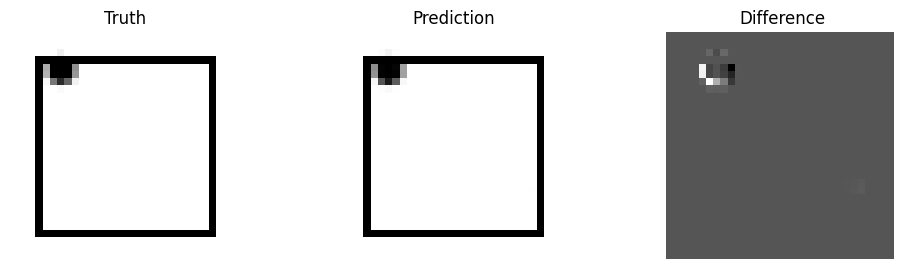


Performance on the prediction task:


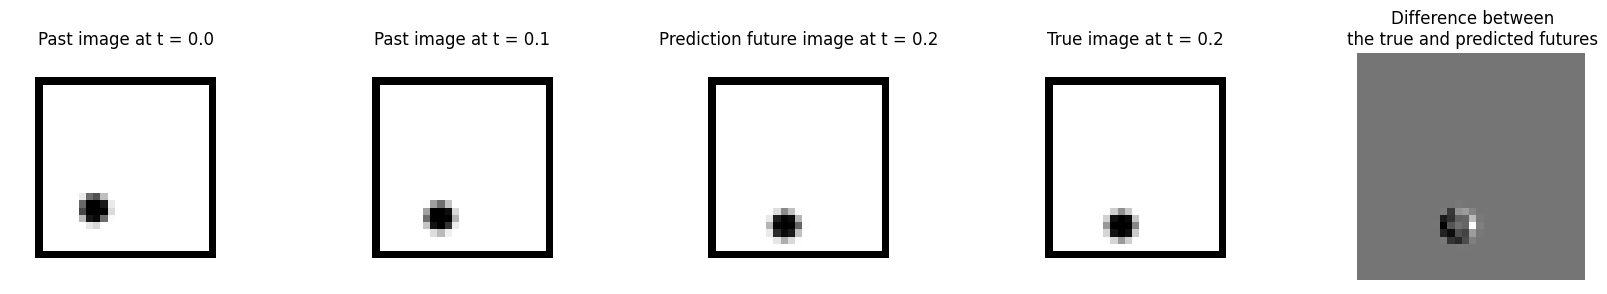

In [15]:
# We can then see how well this model performs pure reconstruction
# (i.e., given an image, how well is that image reconstructed after
# passing through the encoder and the decoder).
print("Performance on the reconstruction task:")
pythia.visualization.reconstruction(img0[7], encoder, decoder, display_walls=True)

# We can also see how well this model performs at prediction.
# (However, as mentioned above, the predictive ability of this model
# is not the main takeaway; the main takeaway is how that is has hopefully
# learned useful embedding faetures.)
print("\nPerformance on the prediction task:")
pythia.visualization.memoryless_prediction(snapshot_timesteps, img0[0], img1[0], img2[0], memoryless_model, display_walls=True)

### Training the full encoder-predictor-decoder architecture